In [1]:
# --- 1. Setup & Libraries ---
import sqlite3
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
SEED = 42
ARTIFACT_DIR = Path("./artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
print("Setup complete and libraries imported.")


Setup complete and libraries imported.


In [50]:
# --- Libraries for ML, NLP, and Plots ---
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,f1_score
from imblearn.over_sampling import SMOTE

from statsmodels.tsa.statespace.sarimax import SARIMAX
import shap

nltk.download('punkt')
nltk.download('wordnet')

print("ML, NLP, SARIMA, SHAP libraries imported.")


ML, NLP, SARIMA, SHAP libraries imported.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
# --- 2. Database Connection and Loading ---
DB_PATH = r"C:\Users\HP\Desktop\proj1\proj1\db\pharma.db"
assert Path(DB_PATH).exists(), "DB path not found."
conn = sqlite3.connect(DB_PATH)

patients = pd.read_sql("SELECT * FROM patients", conn)
labs = pd.read_sql("SELECT * FROM labs", conn)
prescriptions = pd.read_sql("SELECT * FROM prescriptions", conn)
sales = pd.read_sql("SELECT * FROM sales_monthly", conn)
ae_reports = pd.read_sql("SELECT * FROM ae_reports", conn)

print("Data loaded from database successfully.")


Data loaded from database successfully.


In [35]:
# --- Preview each dataset ---
print("--- Patients ---")
display(patients.head())

print("--- Labs ---")
display(labs.head())

print("--- Prescriptions ---")
display(prescriptions.head())

print("--- Sales ---")
display(sales.head())

print("--- AE Reports ---")
display(ae_reports.head())


--- Patients ---


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease
0,100000,61,M,22.3,0,126,273,0,0,0
1,100001,53,M,24.3,0,92,220,0,0,0
2,100002,63,M,25.6,0,110,246,0,1,0
3,100003,73,M,32.3,0,117,244,0,1,0
4,100004,52,M,21.2,0,146,120,0,1,0


--- Labs ---


,lab_id,patient_id,lab_date,ldl,hdl,hba1c
0,1,100000,2024-12-29,168.8,49.0,5.0
1,2,100000,2025-05-05,181.6,59.0,4.9
2,3,100001,2023-05-12,145.4,61.5,6.5
3,4,100002,2023-09-27,137.1,47.5,5.6
4,5,100003,2022-08-23,156.7,61.2,6.0


--- Prescriptions ---


,rx_id,patient_id,rx_date,drug,dose_mg,therapeutic_area,drug_class
0,1,100000,2022-07-10,ALBURX,10,IMM,vaccine
1,2,100001,2024-05-30,ATORVASTATIN,40,CV,statin
2,3,100002,2024-08-05,SIMVASTATIN,20,CV,statin
3,4,100002,2024-09-26,SIMVASTATIN,10,CV,statin
4,5,100002,2022-09-04,ALBURX,10,IMM,vaccine


--- Sales ---


,id,drug,month,units,unit_price,revenue
0,1,ATORVASTATIN,2021-01-01,12421,0.6,7452.6
1,2,ATORVASTATIN,2021-02-01,11385,0.6,6831.0
2,3,ATORVASTATIN,2021-03-01,12816,0.6,7689.6
3,4,ATORVASTATIN,2021-04-01,12033,0.6,7219.8
4,5,ATORVASTATIN,2021-05-01,13891,0.6,8334.6


--- AE Reports ---


,report_id,text,label
0,1,anaphylaxis | shortness of breath,serious
1,2,fatigue,nonserious
2,3,shortness of breath,serious
3,4,arrhythmia,serious
4,5,headache,nonserious


In [65]:
# --- Summary statistics for numerical columns in each dataset ---
print("\n--- Patient Data Summary ---")
display(patients.describe())

print("\n--- Labs Data Summary ---")
display(labs.describe())

print("\n--- Prescriptions Data Summary ---")
display(prescriptions.describe())

print("\n--- Sales Data Summary ---")
display(sales.describe())

print("\n--- AE Reports Data Summary ---")
display(ae_reports.describe())


--- Patient Data Summary ---


,patient_id,age,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,102499.500000,55.054800,27.031860,0.260200,129.864000,210.414800,0.182600,0.347000,0.028800
std,1443.520003,11.929772,4.909778,0.438787,14.940822,43.425765,0.386377,0.476063,0.167261
min,100000.000000,18.000000,15.000000,0.000000,90.000000,120.000000,0.000000,0.000000,0.000000
25%,101249.750000,47.000000,23.700000,0.000000,120.000000,179.000000,0.000000,0.000000,0.000000
50%,102499.500000,55.000000,27.000000,0.000000,130.000000,210.000000,0.000000,0.000000,0.000000
75%,103749.250000,63.000000,30.300000,1.000000,140.000000,240.000000,0.000000,1.000000,0.000000
max,104999.000000,90.000000,44.100000,1.000000,189.000000,355.000000,1.000000,1.000000,1.000000



--- Labs Data Summary ---


,lab_id,patient_id,lab_date,ldl,hdl,hba1c
count,10011.000000,10011.000000,10011,10011.000000,10011.000000,10011.000000
mean,5006.000000,102500.179602,2023-10-14 13:33:51.405454080,137.104665,52.802477,5.627260
min,1.000000,100000.000000,2022-01-01 00:00:00,50.000000,20.000000,4.500000
25%,2503.500000,101251.500000,2022-11-21 00:00:00,115.300000,47.000000,5.100000
50%,5006.000000,102504.000000,2023-10-17 00:00:00,136.800000,52.700000,5.500000
75%,7508.500000,103726.000000,2024-09-02 00:00:00,158.600000,58.500000,6.100000
max,10011.000000,104999.000000,2025-07-31 00:00:00,253.200000,83.700000,8.600000
std,2890.071106,1438.485289,NaN,31.871921,8.540936,0.736084



--- Prescriptions Data Summary ---


,rx_id,patient_id,rx_date,dose_mg
count,7536.000000,7536.000000,7536,7536.000000
mean,3768.500000,102509.697585,2023-10-21 13:43:56.942674944,37.870223
min,1.000000,100000.000000,2022-01-01 00:00:00,10.000000
25%,1884.750000,101258.000000,2022-11-26 00:00:00,20.000000
50%,3768.500000,102491.500000,2023-10-17 00:00:00,40.000000
75%,5652.250000,103772.250000,2024-09-15 06:00:00,80.000000
max,7536.000000,104999.000000,2025-07-31 00:00:00,80.000000
std,2175.600147,1447.760361,NaN,27.058189



--- Sales Data Summary ---


,id,month,units,unit_price,revenue
count,165.000000,165,165.000000,165.000000,165.000000
mean,83.000000,2023-04-01 17:53:27.272727296,12274.939394,3.333333,25185.801212
min,1.000000,2021-01-01 00:00:00,4679.000000,0.400000,5410.800000
25%,42.000000,2022-02-01 00:00:00,7825.000000,0.400000,6840.000000
50%,83.000000,2023-04-01 00:00:00,13604.000000,0.600000,8186.400000
75%,124.000000,2024-06-01 00:00:00,15947.000000,9.000000,51732.000000
max,165.000000,2025-07-01 00:00:00,18603.000000,9.000000,82233.000000
std,47.775517,NaN,4206.242318,4.019970,25920.868413



--- AE Reports Data Summary ---


,report_id
count,2000.000000
mean,1000.500000
std,577.494589
min,1.000000
25%,500.750000
50%,1000.500000
75%,1500.250000
max,2000.000000


In [66]:
# --- Dataset Info Summary ---
print("\n--- Patients Info ---")
patients.info()

print("\n--- Labs Info ---")
labs.info()

print("\n--- Prescriptions Info ---")
prescriptions.info()

print("\n--- Sales Info ---")
sales.info()

print("\n--- AE Reports Info ---")
ae_reports.info()



--- Patients Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     5000 non-null   int64  
 1   age            5000 non-null   int64  
 2   sex            5000 non-null   object 
 3   bmi            5000 non-null   float64
 4   smoker         5000 non-null   int64  
 5   bp_sys         5000 non-null   int64  
 6   cholesterol    5000 non-null   int64  
 7   diabetes       5000 non-null   int64  
 8   statin_use     5000 non-null   int64  
 9   heart_disease  5000 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 390.8+ KB

--- Labs Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10011 entries, 0 to 10010
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   lab_id      10011 non-null  int64         
 1   pa

In [67]:
print("\n--- Missing Values ---")
print("Patients:\n", patients.isnull().sum())
print("\nLabs:\n", labs.isnull().sum())
print("\nPrescriptions:\n", prescriptions.isnull().sum())
print("\nSales:\n", sales.isnull().sum())
print("\nAE Reports:\n", ae_reports.isnull().sum())


--- Missing Values ---
Patients:
 patient_id       0
age              0
sex              0
bmi              0
smoker           0
bp_sys           0
cholesterol      0
diabetes         0
statin_use       0
heart_disease    0
dtype: int64

Labs:
 lab_id        0
patient_id    0
lab_date      0
ldl           0
hdl           0
hba1c         0
dtype: int64

Prescriptions:
 rx_id               0
patient_id          0
rx_date             0
drug                0
dose_mg             0
therapeutic_area    0
drug_class          0
dtype: int64

Sales:
 id            0
drug          0
month         0
units         0
unit_price    0
revenue       0
dtype: int64

AE Reports:
 report_id    0
text         0
label        0
dtype: int64


In [38]:
# ================= Cell 3: Data Cleaning & Missing Values =================
# Patients
patients['bmi'] = patients['bmi'].fillna(patients['bmi'].median())
for col in ['age','smoker','bp_sys','cholesterol','diabetes','statin_use','heart_disease']:
    patients_df[col] = pd.to_numeric(patients_df[col], errors='coerce')

# Labs
labs['lab_date'] = pd.to_datetime(labs['lab_date'], errors='coerce')
for col in ['ldl','hdl','hba1c']:
    labs[col] = pd.to_numeric(labs[col], errors='coerce').fillna(labs[col].median())

# Prescriptions
prescriptions['rx_date'] = pd.to_datetime(prescriptions['rx_date'], errors='coerce')

# Sales
sales['month'] = pd.to_datetime(sales['month'], errors='coerce')

# AE Reports
ae_df = ae_reports.dropna(subset=['text','label']).copy()

print("Data cleaning done. Missing values handled where needed.")



Data cleaning done. Missing values handled where needed.


In [39]:
print("--- Checking Missing Values After Cleaning ---\n")

# Check Patients DataFrame
print("Patients DataFrame (patients):")
print(patients.isna().sum())
print("-" * 30)

# Check Labs DataFrame
print("\nLabs DataFrame (labs):")
print(labs.isna().sum())
print("-" * 30)

# Check Prescriptions DataFrame
print("\nPrescriptions DataFrame (prescriptions):")
print(prescriptions.isna().sum())
print("-" * 30)

# Check Sales DataFrame
print("\nSales DataFrame (sales):")
print(sales.isna().sum())
print("-" * 30)

# Check AE Reports DataFrame
print("\nAdverse Event Reports DataFrame (ae_reports):")
print(ae_reports.isna().sum())
print("-" * 30)

--- Checking Missing Values After Cleaning ---

Patients DataFrame (patients):
patient_id       0
age              0
sex              0
bmi              0
smoker           0
bp_sys           0
cholesterol      0
diabetes         0
statin_use       0
heart_disease    0
dtype: int64
------------------------------

Labs DataFrame (labs):
lab_id        0
patient_id    0
lab_date      0
ldl           0
hdl           0
hba1c         0
dtype: int64
------------------------------

Prescriptions DataFrame (prescriptions):
rx_id               0
patient_id          0
rx_date             0
drug                0
dose_mg             0
therapeutic_area    0
drug_class          0
dtype: int64
------------------------------

Sales DataFrame (sales):
id            0
drug          0
month         0
units         0
unit_price    0
revenue       0
dtype: int64
------------------------------

Adverse Event Reports DataFrame (ae_reports):
report_id    0
text         0
label        0
dtype: int64
------------

In [40]:
# ================= Cell 4: Feature Engineering =================
# Get latest lab per patient
latest_labs = labs.sort_values('lab_date').groupby('patient_id').tail(1)

# Ever had statin prescription
statin_rx = prescriptions_df[prescriptions_df['drug_class'] == 'statin'].groupby('patient_id')['drug_class'].count().reset_index()
statin_rx['ever_statin'] = 1

# Merge features
features_df = patients_df.merge(latest_labs, on='patient_id', how='left') \
                         .merge(statin_rx[['patient_id','ever_statin']], on='patient_id', how='left')
features_df['ever_statin'] = features_df['ever_statin'].fillna(0)

# Encode sex
features_df['sex'] = features_df['sex'].map({'M':1, 'F':0})

# Fill remaining missing numeric values
features_df.fillna(0, inplace=True)

print("Feature engineering done. Features ready for modeling.")
features_df.head()


Feature engineering done. Features ready for modeling.


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease,lab_id,lab_date,ldl,hdl,hba1c,ever_statin
0,100000,61,1,22.3,0,126,273,0,0,0,2,2025-05-05,181.6,59.0,4.9,0.0
1,100001,53,1,24.3,0,92,220,0,0,0,3,2023-05-12,145.4,61.5,6.5,1.0
2,100002,63,1,25.6,0,110,246,0,1,0,4,2023-09-27,137.1,47.5,5.6,1.0
3,100003,73,1,32.3,0,117,244,0,1,0,6,2024-08-22,148.4,59.7,5.3,0.0
4,100004,52,1,21.2,0,146,120,0,1,0,8,2022-10-04,52.4,57.8,5.5,1.0


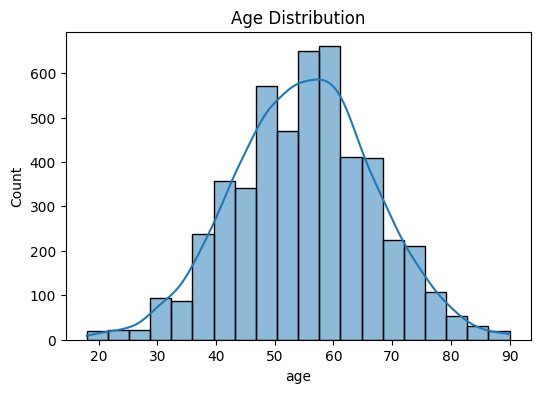

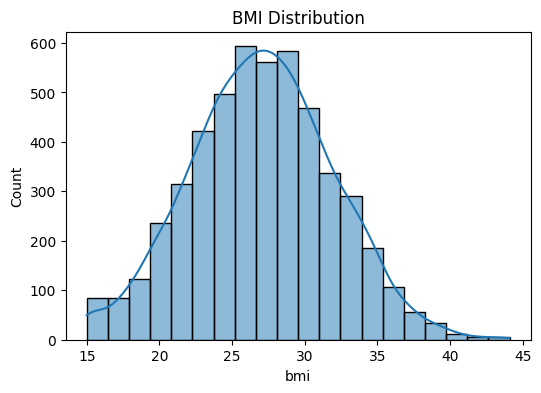

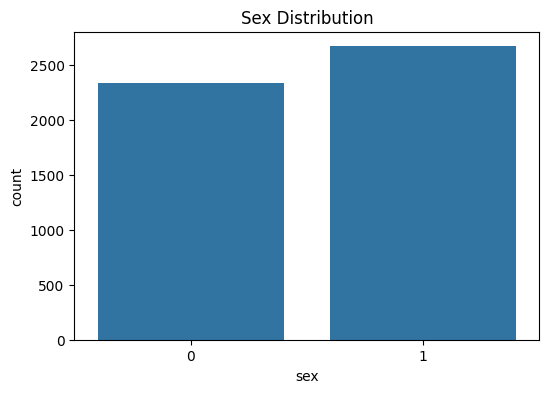

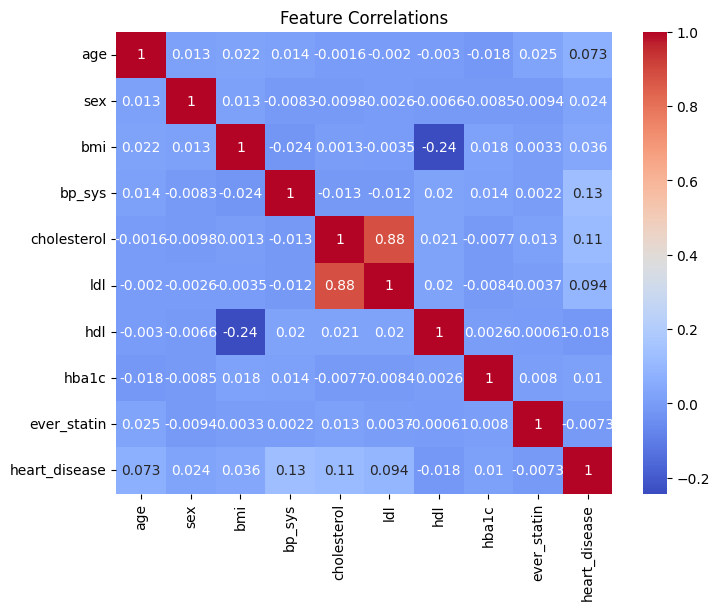

In [42]:
# ================= Cell 5: Exploratory Data Analysis (EDA) =================
import matplotlib.pyplot as plt
import seaborn as sns

# Basic distributions

plt.figure(figsize=(6,4))
sns.histplot(features_df['age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(features_df['bmi'], kde=True, bins=20)
plt.title("BMI Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=features_df)
plt.title("Sex Distribution")
plt.show()

# Correlation matrix
plt.figure(figsize=(8,6))
corr = features_df[['age','sex','bmi','bp_sys','cholesterol','ldl','hdl','hba1c','ever_statin','heart_disease']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       971
           1       0.08      0.79      0.15        29

    accuracy                           0.74      1000
   macro avg       0.54      0.77      0.50      1000
weighted avg       0.97      0.74      0.83      1000

LogisticRegression Confusion Matrix:
[[717 254]
 [  6  23]]



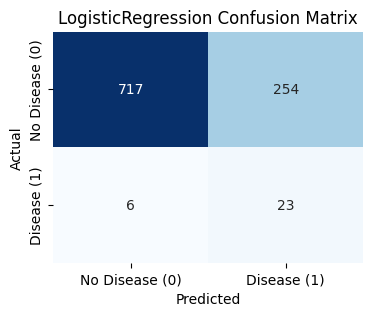


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       971
           1       0.15      0.24      0.18        29

    accuracy                           0.94      1000
   macro avg       0.56      0.60      0.58      1000
weighted avg       0.95      0.94      0.95      1000

RandomForest Confusion Matrix:
[[931  40]
 [ 22   7]]



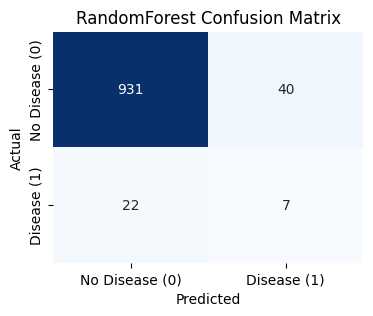


GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       971
           1       0.10      0.52      0.16        29

    accuracy                           0.85      1000
   macro avg       0.54      0.69      0.54      1000
weighted avg       0.96      0.85      0.89      1000

GradientBoosting Confusion Matrix:
[[831 140]
 [ 14  15]]



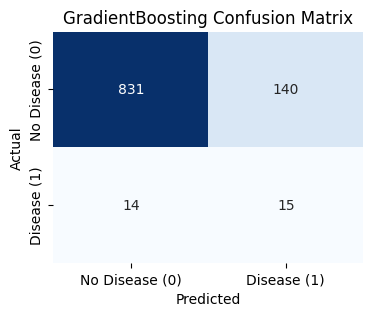

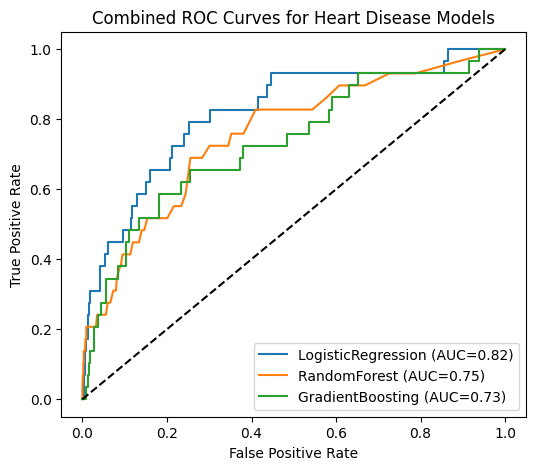

In [60]:


# ================= Cell 2: Feature Setup =================
# X = features, y = target
X = features_df[['age','sex','bmi','bp_sys','cholesterol','ldl','hdl','hba1c','ever_statin']]
y = features_df['heart_disease']

# ================= Cell 3: Train-Test Split =================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================= Cell 4: Scaling =================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# ================= Cell 5: Handle Class Imbalance =================
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_s, y_train)

# ================= Cell 6: Model Setup =================
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# ================= Cell 7: Train & Evaluate =================
roc_scores = {}
roc_curves = {}

for name, model in models.items():
    # Train
    model.fit(X_train_bal, y_train_bal)
    # Predict probabilities
    y_proba = model.predict_proba(X_test_s)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)

    # ---- Classification Report ----
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:\n{cm}\n")

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Disease (0)", "Disease (1)"],
                yticklabels=["No Disease (0)", "Disease (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ---- ROC Data ----
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_scores[name] = roc_auc_score(y_test, y_proba)
    roc_curves[name] = (fpr, tpr)

# ================= Cell 8: Combined ROC Curve =================
plt.figure(figsize=(6,5))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_scores[name]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves for Heart Disease Models")
plt.legend()
plt.show()


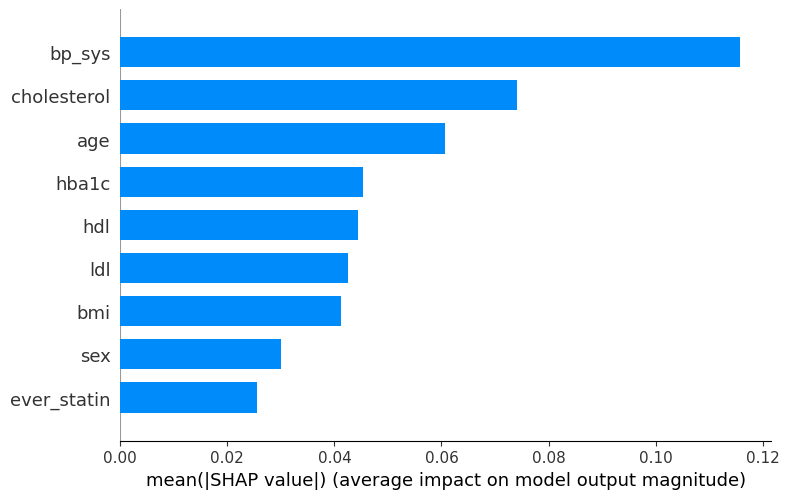

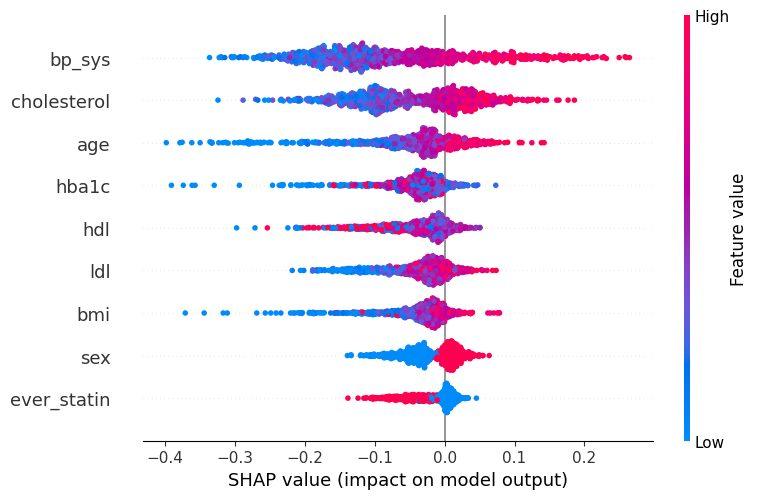

In [45]:
# ================= Cell 7: SHAP Feature Importance =================

# Use RandomForest for SHAP (or best model from previous step)
best_model = models["RandomForest"]

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_s)[1]  # 1 = positive class

# Summary plot (bar)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=True)

# Optional: Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="dot", show=True)


Forecast Accuracy for ATORVASTATIN:
  RMSE: 645.86
  MAE : 522.44
  MAPE: 3.71%


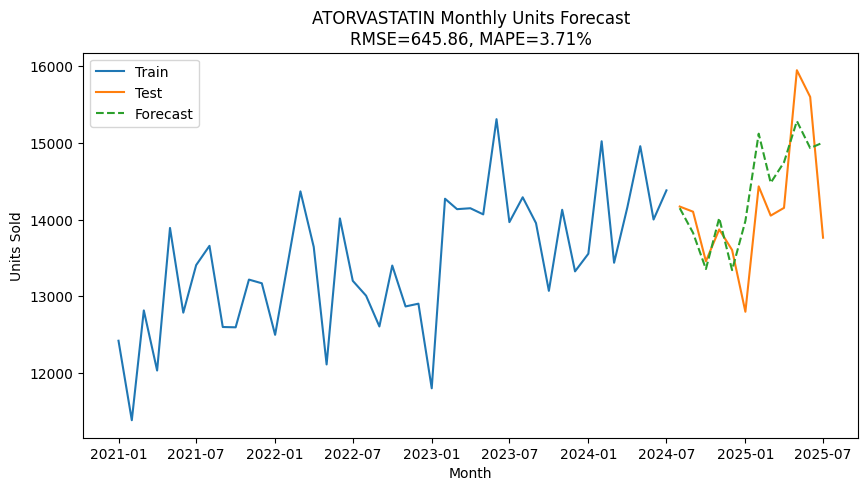

In [61]:
# ================= Cell 8: SARIMA Sales Forecasting =================

# Aggregate monthly sales units per drug (example: ATORVASTATIN)
sales["units"] = pd.to_numeric(sales["units"], errors="coerce")

drug = "ATORVASTATIN"
ts = sales[sales["drug"]==drug].set_index("month")["units"].asfreq("MS")

# Only forecast if enough data
if len(ts) >= 24:
    train = ts.iloc[:-12]
    test = ts.iloc[-12:]

    # Fit SARIMA (seasonal)
    sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_fit = sarima_model.fit(disp=False)

    # Forecast
    forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

    # --- 📐 Forecast Accuracy Metrics ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = np.mean(np.abs((test - forecast) / test)) * 100

    print(f"Forecast Accuracy for {drug}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  MAPE: {mape:.2f}%")

    # --- 📊 Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, forecast, "--", label="Forecast")
    plt.title(f"{drug} Monthly Units Forecast\nRMSE={rmse:.2f}, MAPE={mape:.2f}%")
    plt.xlabel("Month")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       206
           1       0.80      0.95      0.87       194

    accuracy                           0.86       400
   macro avg       0.88      0.87      0.86       400
weighted avg       0.88      0.86      0.86       400

ROC-AUC: 0.8832073866479832
F1 Score: 0.8726415094339622


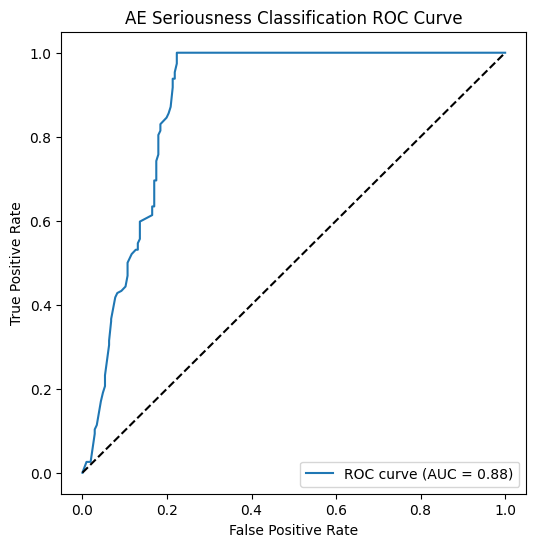

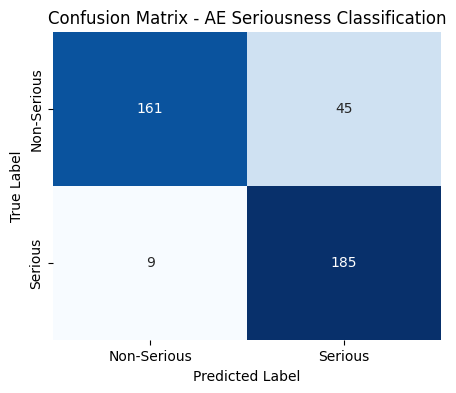

In [64]:
# --- 8. AE NLP Classification ---

ae_df_clean = ae_reports.dropna(subset=["text", "label"]).copy()
ae_df_clean["y"] = (ae_df_clean["label"].str.lower() == "serious").astype(int)

# --- 2. Text Preprocessing: Lemmatization ---
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    return " ".join([lemmatizer.lemmatize(tok) for tok in tokens])

ae_df_clean["text_lemmatized"] = ae_df_clean["text"].apply(lemmatize_text)

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    ae_df_clean["text_lemmatized"],
    ae_df_clean["y"],
    test_size=0.2,
    stratify=ae_df_clean["y"],
    random_state=42
)

# --- 4. Pipeline: TF-IDF + Logistic Regression ---
ae_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# --- 5. Train Model ---
ae_pipe.fit(X_train, y_train)

# --- 6. Predictions ---
y_proba = ae_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# --- 7. Evaluation Metrics ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))

# --- 8. ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AE Seriousness Classification ROC Curve")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Serious", "Serious"],
            yticklabels=["Non-Serious", "Serious"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - AE Seriousness Classification")
plt.show()



In [ ]:
# --- 9. Cleanup ---
conn.close()
print("\n✅  completed!")
